### Import packages

In [1]:
from Bio import SeqIO
from matplotlib import pyplot as plt
import os
import numpy as np

In [2]:
# this block is used to define variables to be used later
fasta_file_path = "../1-get_cycog/data/CyCOG_60000117.prfg.faa"  # Add your FASTA file path here
# tolerance will either be a chosen number of amino acids or based on the standard deviation of sequence length
# tolerance = (0, 0)
tolerance = "std"


### The block below takes a fasta inputted and displays a histogram showing the sequence length distribution within the fasta.

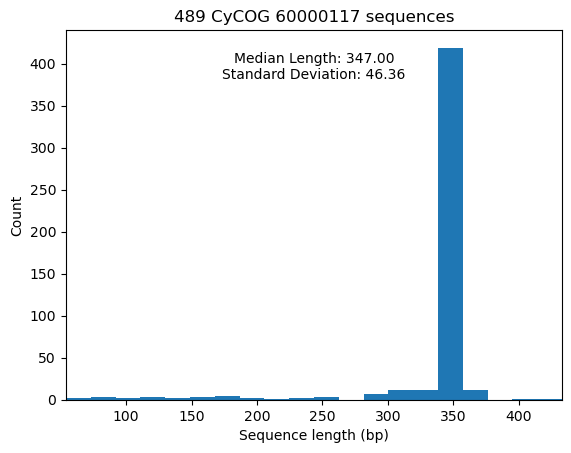

In [3]:

# Extract the number before the first dot in the file name
cy_cog_number = os.path.basename(fasta_file_path).split("_")[1].split(".")[0]

# Parse the FASTA file and get sequence lengths
sizes = [len(rec) for rec in SeqIO.parse(fasta_file_path, "fasta")]

# Parse the input FASTA file and calculate median and standard deviation
sequences = []
for seq_record in SeqIO.parse(fasta_file_path, "fasta"):
    sequences.append(seq_record)
sequence_lengths = np.array([len(seq) for seq in sequences])
median_length = np.median(sequence_lengths)
std_dev = np.std(sequence_lengths)
lower_lim = sequence_lengths.min()
upper_lim = sequence_lengths.max()



# Plot histogram
plt.hist(sizes, bins=20)
plt.title(f"{len(sizes)} CyCOG {cy_cog_number} sequences")
plt.xlabel("Sequence length (bp)")
plt.ylabel("Count")
plt.xlim((lower_lim,upper_lim))

# Annotate median and standard deviation on the histogram
plt.text(0.5, 0.9, f'Median Length: {median_length:.2f}\nStandard Deviation: {std_dev:.2f}',
           horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

plt.show()


### The block below makes a new fasta, filtering out sequences outside of one standard deviation from the median length.

In [4]:
# Define filter limits
if tolerance == "std":
    tol_low = std_dev
    tol_high = std_dev
else:
    tol_low = tolerance[0]
    tol_high = tolerance[1]

# Define output file path based on CyCOG number
output_fasta_path = os.path.join("data", f"{cy_cog_number}_filtered.fasta")

# Filter sequences based on one standard deviation from the median
filtered_sequences = [seq for seq in sequences if len(seq) >= median_length - tol_low and len(seq) <= median_length + tol_high]

# Write filtered sequences to the output FASTA file
with open(output_fasta_path, "w") as output_file:
    SeqIO.write(filtered_sequences, output_file, "fasta")



### The block below makes a new histogram with the new fasta and saves it.

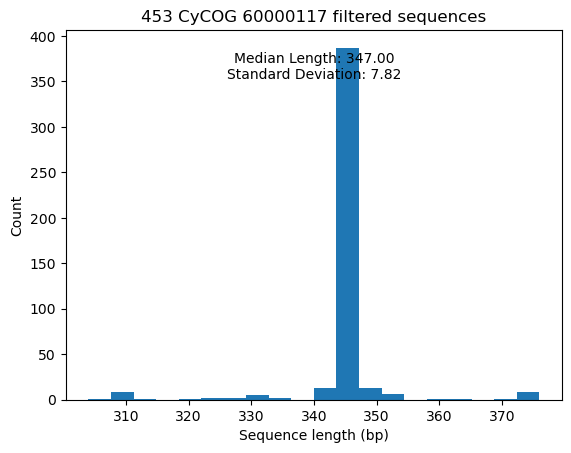

In [5]:
# Calculate median and standard deviation
sequence_lengths = np.array([len(seq) for seq in filtered_sequences])
median_length = np.median(sequence_lengths)
std_dev = np.std(sequence_lengths)

# Plot histogram
plt.hist(sequence_lengths, bins=20)
plt.title(f"{len(sequence_lengths)} filtered CyCOG {cy_cog_number} sequences")
plt.xlabel("Sequence length (bp)")
plt.ylabel("Count")
# plt.xlim((lower_lim,upper_lim)) #use this line if you want to use the first plot x axis range

# Annotate median and standard deviation on the histogram
plt.text(0.5, 0.9, f'Median Length: {median_length:.2f}\nStandard Deviation: {std_dev:.2f}',
           horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Save the histogram output inside the "data" directory
output_histogram_path = os.path.join("data", f"{cy_cog_number}_hist.png")
plt.savefig(output_histogram_path, bbox_inches='tight')

plt.show()
